In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from tqdm import tqdm

In [102]:
import sealgw
from pycbc.conversions import mchirp_from_mass1_mass2, q_from_mass1_mass2
from spiir.data.waveform import cbc
from sealgw.simulation.generating_data import (
    generate_random_injection_parameters, zip_injection_parameters
)
from spiir.data.parameter.distribution import (
    Distribution, NumPyDistribution, JointDistribution
)

In [70]:
mass_distributions = JointDistribution(
    distributions=[
        NumPyDistribution("mass_1", "uniform", low=1.4, high=3), 
        NumPyDistribution("mass_2", "uniform", low=1.4, high=3)
    ],
    pipe=[
        lambda df: df.loc[df["mass_1"] >= df["mass_2"]],
        # lambda df: df.assign(chirp_mass=mchirp_from_mass1_mass2(df["mass_1"], df["mass_2"])),
        # lambda df: df.assign(mass_ratio=q_from_mass1_mass2(df.pop("mass_1"), df.pop("mass_2"))),
    ]
)

spin_column_map = dict(a_1="chi_1", a_2="chi_2", tilt_1="theta_1", tilt_2="theta_2")
spin_distributions = JointDistribution(
    distributions=[
        NumPyDistribution('a_1', "uniform", low=0, high=0.97),
        NumPyDistribution('a_2', "uniform", low=0, high=0.97),
        NumPyDistribution('tilt_1', "uniform", low=0, high=0),
        NumPyDistribution('tilt_2', "uniform", low=0, high=0),
        NumPyDistribution('phi_12', "uniform", low=0, high=0),
        NumPyDistribution('phi_jl', "uniform", low=0, high=0),
        NumPyDistribution(
            'theta_jn',
            "uniform",
            low=-1,
            pipe=[lambda df: df.assign(theta_jn=np.arccos(df["theta_jn"]))]
        )
    ],
    pipe=[lambda df: df.rename(columns=spin_column_map)]
)

intrinsic_distributions = JointDistribution(
    [mass_distributions, spin_distributions]
)

extrinsic_distributions = JointDistribution(
    distributions=[
        NumPyDistribution('psi', "uniform", low=0, high=np.pi),
        NumPyDistribution('phase', "uniform", low=0, high=2*np.pi),
        NumPyDistribution('ra', "uniform", low=0, high=2*np.pi),
        NumPyDistribution(
            'dec',
            "uniform",
            low=-1,
            pipe=[lambda df: df.assign(dec=np.arcsin(df['dec']))]
        ),
        NumPyDistribution(
            "d_L",
            "power",
            a=3,
            pipe=[lambda df: df.assign(d_L=df["d_L"] * (3 - 1) + 1),]
        ),
        NumPyDistribution('geocent_time', "uniform", low=0, high=3.14e7)
    ],
    pipe=[lambda df: df.rename(columns={"d_L": "luminosity_distance"})]
)

In [71]:
distributions=[intrinsic_distributions, extrinsic_distributions]
priors = JointDistribution(distributions)

In [72]:
n_samples = 100000

In [73]:
# %%timeit
samples = priors.draw(n_samples)
samples

,mass_1,mass_2,chi_1,chi_2,theta_1,theta_2,phi_12,phi_jl,theta_jn,psi,phase,ra,dec,luminosity_distance,geocent_time
0,2.982648,2.007087,0.062011,0.790105,0.0,0.0,0.0,0.0,2.226962,2.835064,0.343641,5.842852,-0.023627,2.585685,2.985505e+07
1,1.958875,1.416803,0.094271,0.788157,0.0,0.0,0.0,0.0,0.368463,2.523246,1.120530,1.075732,0.069019,1.681974,2.466413e+07
2,2.150771,1.991061,0.876953,0.109531,0.0,0.0,0.0,0.0,3.054505,2.794447,4.162704,3.178594,1.106620,2.350504,1.147705e+07
3,2.597908,2.454934,0.380483,0.071384,0.0,0.0,0.0,0.0,2.045087,1.178939,5.967159,4.508139,-1.332674,2.817718,1.502915e+07
4,2.651148,2.349591,0.137989,0.597086,0.0,0.0,0.0,0.0,1.002876,1.189896,4.847032,0.288115,-0.274170,2.171178,1.374234e+07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,1.775490,1.499278,0.134657,0.279248,0.0,0.0,0.0,0.0,2.078084,1.409315,2.874710,0.926912,-0.864768,2.967508,1.861266e+06
99996,1.855751,1.503866,0.406177,0.276438,0.0,0.0,0.0,0.0,2.290919,2.467955,0.034886,5.914488,1.313566,2.119125,9.443649e+06
99997,2.157543,2.107707,0.901305,0.774337,0.0,0.0,0.0,0.0,1.136060,0.488221,0.679045,1.808875,1.047663,2.824076,2.405388e+07
99998,2.674829,1.961399,0.118707,0.701983,0.0,0.0,0.0,0.0,1.908813,3.107692,3.374201,2.833923,-0.416883,2.750612,8.940907e+06


In [74]:
# %%timeit
sealgw_samples = generate_random_injection_parameters(
    n_samples, 1, 3, 1.4, 3, 0.5, 0.97, 1.4
)

sealgw_samples = pd.DataFrame(sealgw_samples, columns=sealgw.simulation.generating_data.PARAMETERS)
sealgw_samples

,chirp_mass,mass_ratio,a_1,a_2,tilt_1,tilt_2,phi_12,phi_jl,theta_jn,psi,phase,ra,dec,luminosity_distance,geocent_time
0,2.526169,0.970867,0.324015,0.263789,0.0,0.0,0.0,0.0,1.890047,0.785428,4.204196,5.917615,-0.436555,2.623321,2.221073e+07
1,1.802342,0.624185,0.028838,0.854755,0.0,0.0,0.0,0.0,0.394132,1.276701,6.030740,0.362138,-0.051245,1.915572,1.717489e+07
2,1.963329,0.830421,0.606290,0.269851,0.0,0.0,0.0,0.0,1.397716,1.923101,5.447841,3.926588,0.614938,2.530176,1.713276e+07
3,1.446486,0.882909,0.313361,0.227461,0.0,0.0,0.0,0.0,1.294956,1.947043,0.371640,5.381819,0.273214,2.646697,2.222885e+07
4,1.726922,0.627097,0.589166,0.769168,0.0,0.0,0.0,0.0,1.544166,2.297192,5.992792,3.188985,0.857735,2.577570,2.507861e+06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,1.564176,0.869715,0.143566,0.791496,0.0,0.0,0.0,0.0,2.911736,1.982378,4.672553,5.048050,-0.160222,1.897171,2.221821e+07
99996,1.407544,0.950139,0.540372,0.595233,0.0,0.0,0.0,0.0,1.172140,0.964132,6.052077,5.322961,0.280906,2.114240,1.809982e+07
99997,2.032076,0.641962,0.880162,0.226636,0.0,0.0,0.0,0.0,2.766495,0.904210,1.307008,3.924671,0.898685,2.487973,1.177348e+07
99998,1.383166,0.926214,0.437893,0.233839,0.0,0.0,0.0,0.0,1.545830,1.929986,3.111658,0.256895,0.062458,2.841860,2.163890e+07


/tmp/ipykernel_82922/625312779.py:2: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared.
  samples.hist(bins=50, ax=ax)


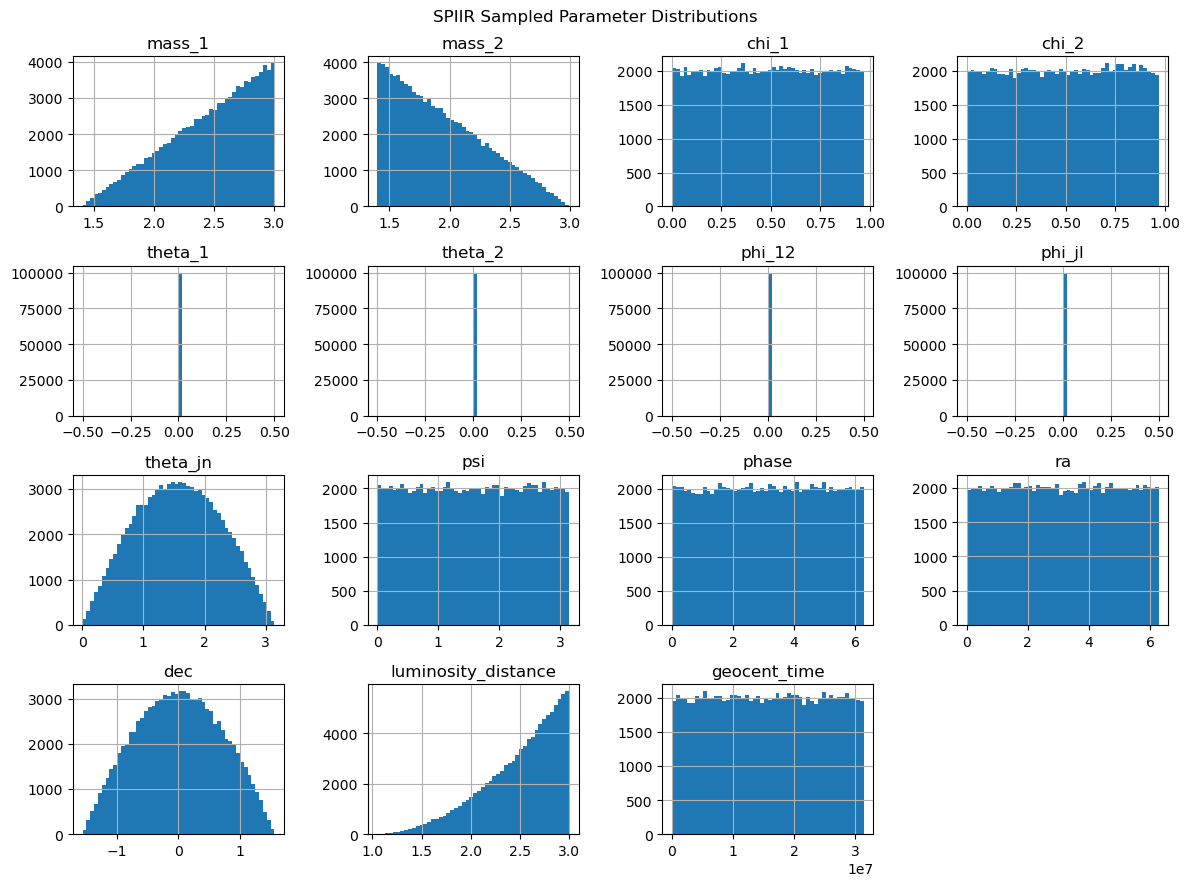

In [75]:
fig, ax = plt.subplots(figsize=(12,9), layout="tight", facecolor="white")
samples.hist(bins=50, ax=ax)
fig.suptitle("SPIIR Sampled Parameter Distributions")
fig;

/tmp/ipykernel_82922/1333467830.py:2: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared.
  sealgw_samples.hist(bins=50, ax=ax)


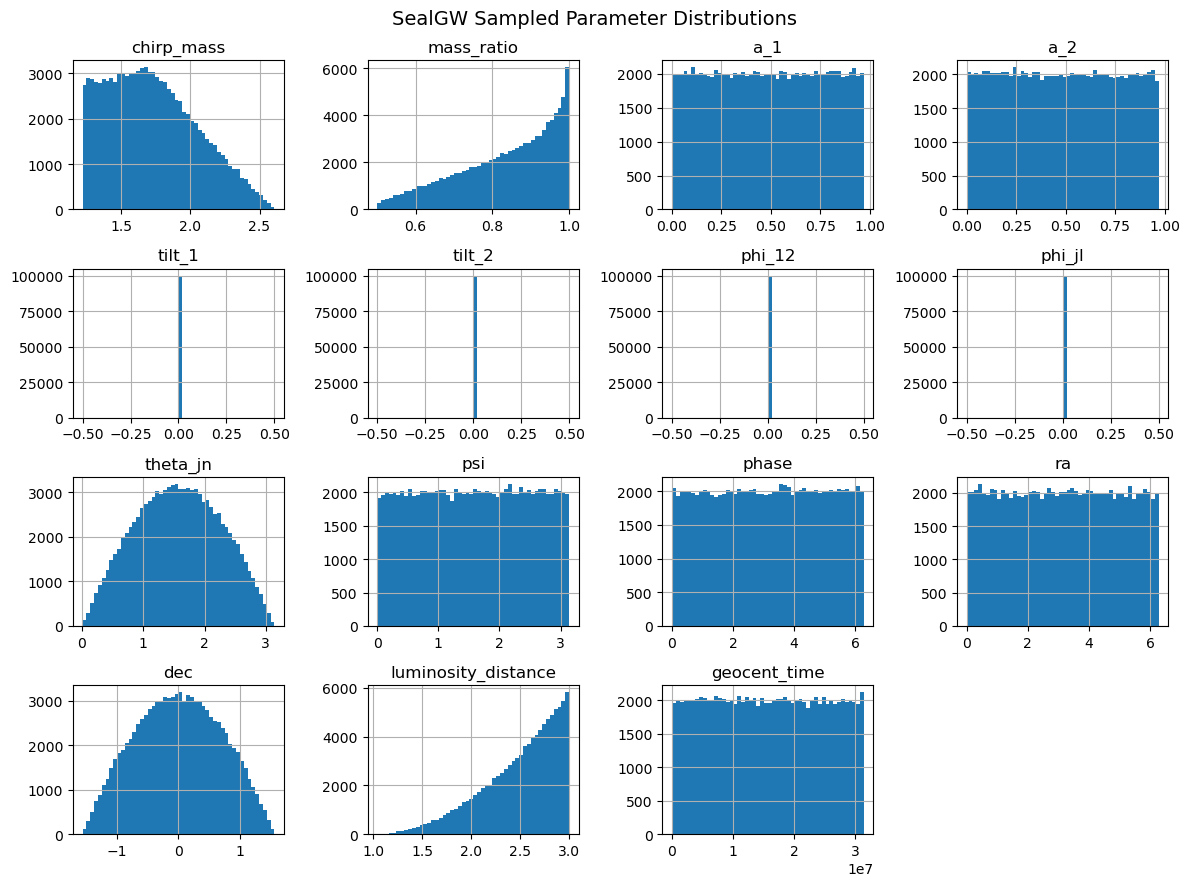

In [76]:
fig, ax = plt.subplots(figsize=(12,9), layout="tight", facecolor="white")
sealgw_samples.hist(bins=50, ax=ax)
fig.suptitle("SealGW Sampled Parameter Distributions", fontsize=14)
fig;

In [77]:
samples

,mass_1,mass_2,chi_1,chi_2,theta_1,theta_2,phi_12,phi_jl,theta_jn,psi,phase,ra,dec,luminosity_distance,geocent_time
0,2.982648,2.007087,0.062011,0.790105,0.0,0.0,0.0,0.0,2.226962,2.835064,0.343641,5.842852,-0.023627,2.585685,2.985505e+07
1,1.958875,1.416803,0.094271,0.788157,0.0,0.0,0.0,0.0,0.368463,2.523246,1.120530,1.075732,0.069019,1.681974,2.466413e+07
2,2.150771,1.991061,0.876953,0.109531,0.0,0.0,0.0,0.0,3.054505,2.794447,4.162704,3.178594,1.106620,2.350504,1.147705e+07
3,2.597908,2.454934,0.380483,0.071384,0.0,0.0,0.0,0.0,2.045087,1.178939,5.967159,4.508139,-1.332674,2.817718,1.502915e+07
4,2.651148,2.349591,0.137989,0.597086,0.0,0.0,0.0,0.0,1.002876,1.189896,4.847032,0.288115,-0.274170,2.171178,1.374234e+07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,1.775490,1.499278,0.134657,0.279248,0.0,0.0,0.0,0.0,2.078084,1.409315,2.874710,0.926912,-0.864768,2.967508,1.861266e+06
99996,1.855751,1.503866,0.406177,0.276438,0.0,0.0,0.0,0.0,2.290919,2.467955,0.034886,5.914488,1.313566,2.119125,9.443649e+06
99997,2.157543,2.107707,0.901305,0.774337,0.0,0.0,0.0,0.0,1.136060,0.488221,0.679045,1.808875,1.047663,2.824076,2.405388e+07
99998,2.674829,1.961399,0.118707,0.701983,0.0,0.0,0.0,0.0,1.908813,3.107692,3.374201,2.833923,-0.416883,2.750612,8.940907e+06


In [78]:
keys = [
    "mass_1", "mass_2", "theta_jn", "theta_1", "theta_2",
]
    "phi_jl", "chi_1", "chi_2", "phi_12", "phase"
]

In [80]:
samples.loc[0, keys].to_dict()

{'mass_1': 2.982647814331436,
 'mass_2': 2.0070865647057428,
 'theta_jn': 2.226961760885831,
 'theta_1': 0.0,
 'theta_2': 0.0,
 'phi_jl': 0.0,
 'chi_1': 0.062011480027517094,
 'chi_2': 0.7901049246790504,
 'phi_12': 0.0,
 'phase': 0.34364129604843274}

In [96]:
# data = {
#     series.name: series.values
#     for series in samples[keys].to_dict(orient="series").values()
# }

In [100]:
data = samples[keys].to_dict(orient="records")

In [109]:
def convert_spin_parameters(df: pd.DataFrame):

    cols = ["incl", "spin_1x", "spin_1y", "spin_1z", "spin_2x", "spin_2y", "spin_2z"]
    parameters = [cbc.transform_precessing_spins(**x) for x in tqdm(df, disable=)]
    data = np.stack(parameters, axis=0)

100%|██████████| 100/100 [00:00<00:00, 1506.96it/s]


In [111]:
pd.DataFrame(precessing_data, columns=precessing_params)

,incl,spin_1x,spin_1y,spin_1z,spin_2x,spin_2y,spin_2z
0,2.226962,0.0,0.0,0.062011,0.0,0.0,0.790105
1,0.368463,0.0,0.0,0.094271,0.0,0.0,0.788157
2,3.054505,-0.0,0.0,0.876953,-0.0,0.0,0.109531
3,2.045087,0.0,0.0,0.380483,0.0,0.0,0.071384
4,1.002876,0.0,0.0,0.137989,0.0,0.0,0.597086
...,...,...,...,...,...,...,...
95,1.655249,-0.0,0.0,0.830226,-0.0,0.0,0.240404
96,1.800194,0.0,0.0,0.869165,0.0,0.0,0.669784
97,2.306946,0.0,0.0,0.335773,0.0,0.0,0.317786
98,1.021686,-0.0,0.0,0.119496,-0.0,0.0,0.584497
